# PDF Processing

This notebook focuses on extracting structured data from LEGO instruction manuals in PDF format. Specifically, we'll use tools for computer vision, OCR and image processing to identify and catalog which LEGO pieces are used in each construction step of a LEGO set by analyzing the manual's PDF content.

The primary goal is to create an automatic tool for parsing LEGO instruction PDFs and generating a comprehensive inventory of pieces organized by construction step. From this information we'll create a database which we'll use later on.

### Imports and definitions

In [10]:
# Autoreload the modules when the source code changes
%load_ext autoreload
%autoreload 2

from pathlib import Path
import sys
import os
import csv

# Code profiling
from cProfile import Profile
from pstats import SortKey, Stats
import time
import fitz

# Get the absolute path of the current directory
current_dir = Path().resolve()
# If we're in the notebooks or src directory, move up one level
# to the project root directory
project_root = current_dir.parent if current_dir.name in ['notebooks', 'src'] else current_dir
# Add the project root directory to Python's path
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))
# Add /src to Python's path
src_dir = project_root / 'src'
if str(src_dir) not in sys.path:
    sys.path.append(str(src_dir))

# Change the current working directory
os.chdir(project_root)

from src.pdf_processor import PDFProcessor
import src.step_detector
from src.utils.logger import setup_logging
from src.piece_matcher import PieceMatcher
from src.data_loader import process_and_load_manual_data
from utils.pdf_parts_list_extractor import extract_parts_list_from_pdf
import logging

logger = logging.getLogger(__name__)

setup_logging(log_to_console=False)

data_dir = Path('data')
images_path = data_dir / 'training' / 'images'
manuals_path = data_dir / 'training' / 'manuals'
manuals_to_sets = manuals_path / 'manuals_to_sets.csv'
inventories_csv = data_dir / 'inventories.csv'
processed_booklets_dir = data_dir / 'processed_booklets'
annotations_file_path = data_dir / 'training' / 'annotations' / 'merged' / 'annotations.json'
db_path = data_dir / 'brickmapper.db'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Training the YOLO Model

YOLO is used to identify step data in the LEGO manuals.
About 500 pages from 4 different manuals were annotated using [CVAT](https://www.cvat.ai/), split into training, validation and test sets (60%, 20%, 20% respectively) and used to train a YOLO11 n model, 
 11 being the latest YOLO version. The 'n' model was chosen due to its size, and has proven to be more than adequate for the task.

Here's an example of an annotated page:
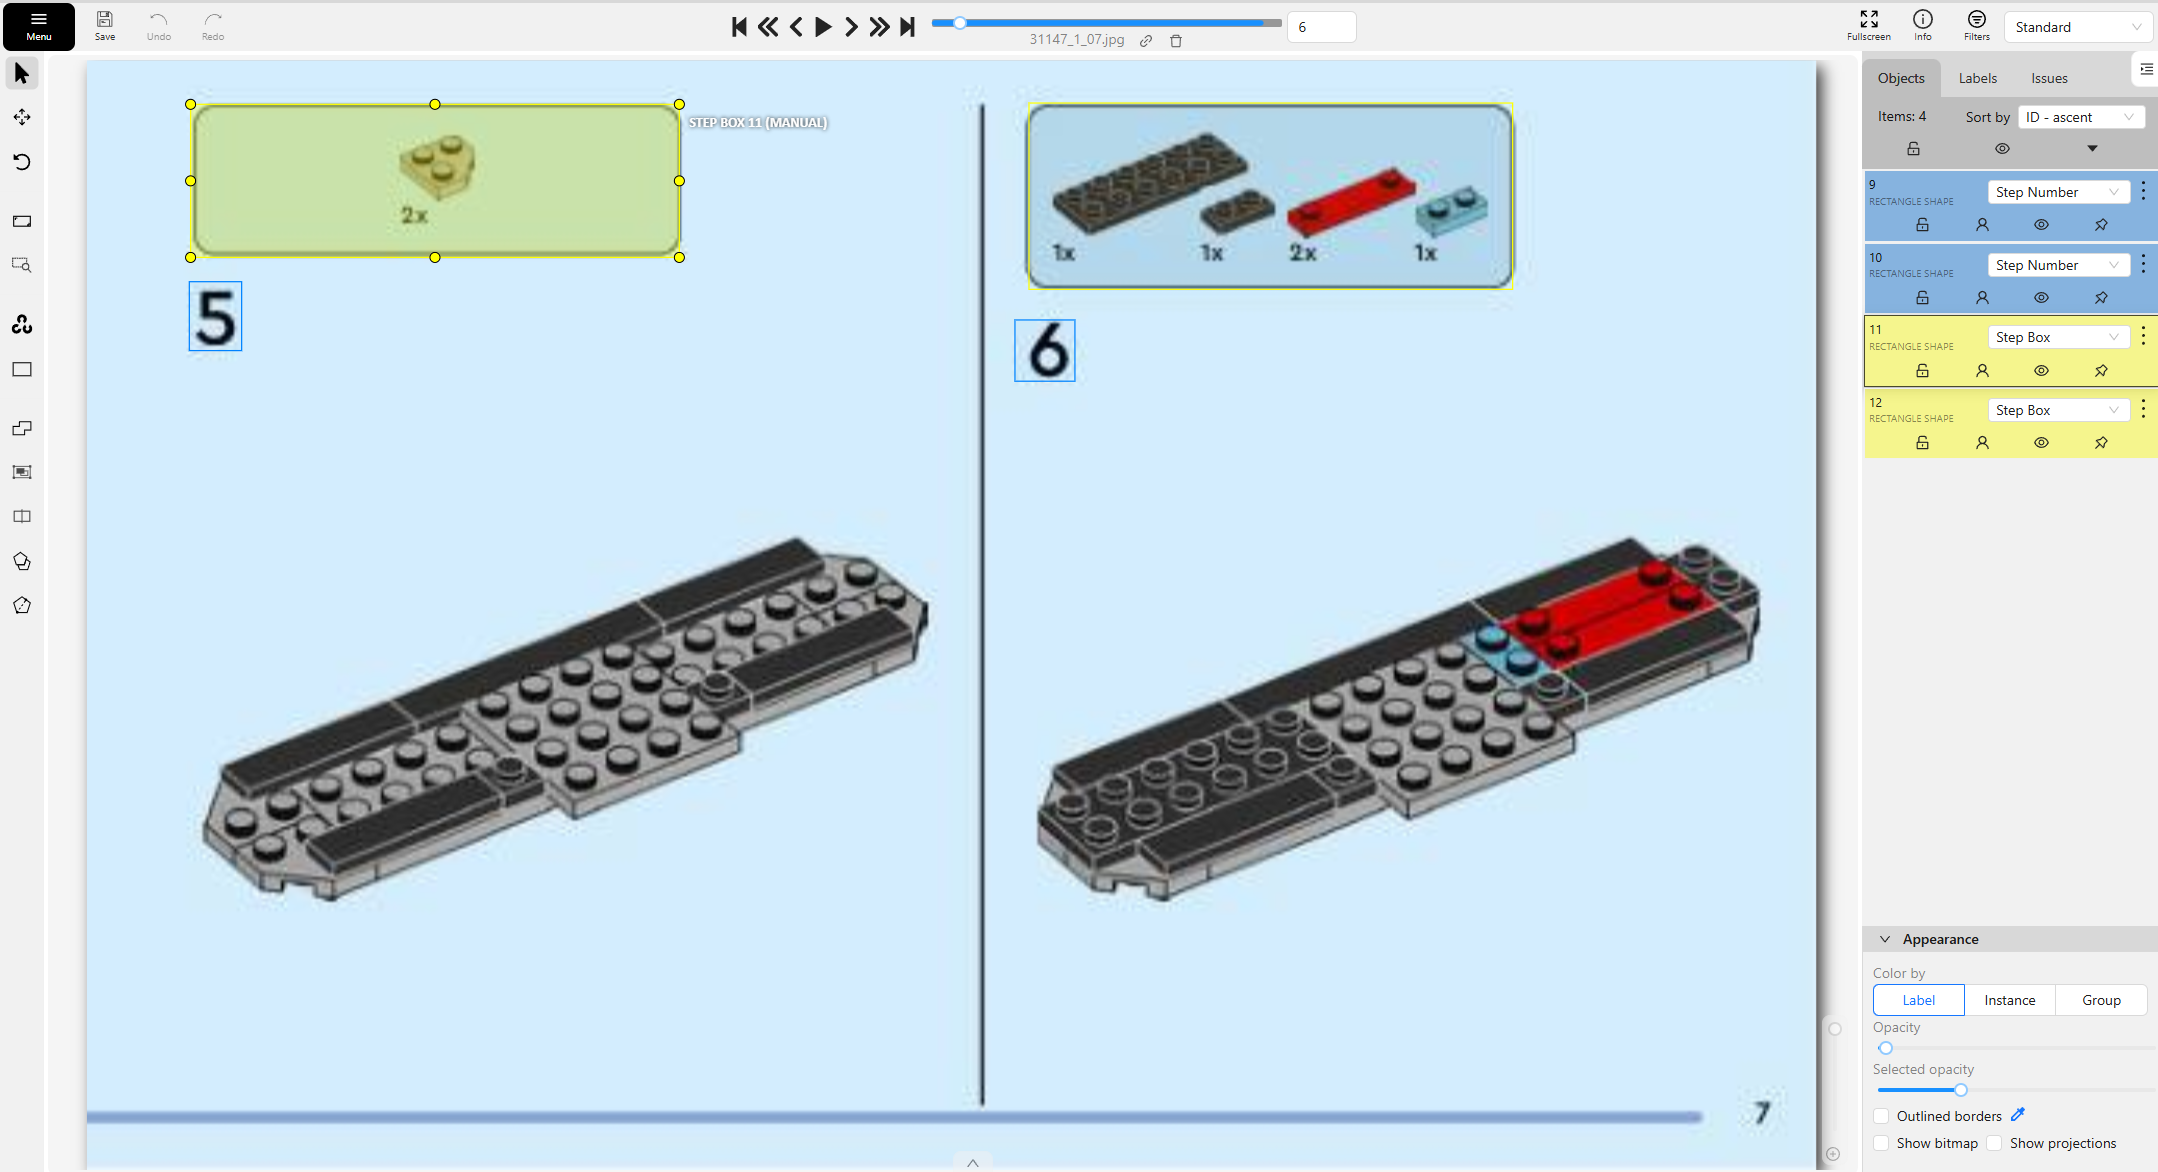

There are two types of annotations:
* Yellow boxes denote step boxes (Where all the parts used for this step are listed)
* Blue boxes denote the step number. Step numbers are usually incremented throughout the build process, but they can some times reset when switching to a new manual, or even within the same manual.
So to make sure location pointers are unique we'll use the set number, booklet number, page number and step number when saving a piece's usage.

In [3]:
# If the model has already been trained, we don't need to train it again
model_path = Path("runs/train/exp/weights/best.pt")

if not model_path.exists():
    step_detector.train_model(images_dir=images_path, annotations_path = annotations_file_path, model_save_path=model_path)

## Processing manuals

Now that the model has been trained we can use it to process manuals it hasn't seen yet.

To process a manual, the following steps should be taken:

* Put a PDF of the manual in `manuals_path`
* Add the manual to the `manuals_to_sets` csv file (Format: manual_ID,set_number,booklet_number)
* Add the manual ID to the `manuals` list below:

In [4]:
manuals = ['6497658', '6497660', '6497659']

In [14]:
# Initialize processors
pdf_processor = PDFProcessor()

with open(manuals_to_sets, "r", newline="") as csvfile:
    reader = csv.reader(csvfile)
    try:
        # Skip the header row
        manuals_dict = {}
        next(reader, None)
        for row in reader:
            manuals_dict[row[0]] = [row[1], row[2]]
    except IndexError:
        logger.error("Error reading manuals to sets CSV file.")
        logger.error(f"Row: {row}")
        sys.exit(1)

pieces_by_steps = {}
all_sets_set_pieces = {}
matchers = {}
documents = {}

st = time.time()
        
with Profile() as profile:
    # Process manuals
    for manual in manuals:
        if manual not in manuals_dict:
            logger.warning(f"Manual ID {manual} not found in manuals dictionary.")
            continue

        # Set up directories
        pdf_path = manuals_path / f"{manual}.pdf"
        documents[manual] = fitz.open(pdf_path)

        # You should only set these directories if you want to save the intermediate images
        # booklet_images_dir = data_dir / "processed_booklets" / manual
        # set_pieces_dir = booklet_images_dir / "set pieces"
        # rejects_dir = booklet_images_dir / "rejected inventory images"

        set_num = manuals_dict[manual][0]
        booklet_num = manuals_dict[manual][1]
        
        parts_list_pages = pdf_processor.find_parts_list_pages(documents[manual])
        if not parts_list_pages:
            # Couldn't find a parts list in the manual.
            # We'll check later if other manuals from the same set have one
            continue

        if set_num not in all_sets_set_pieces:
            all_sets_set_pieces[set_num] = {}

        all_sets_set_pieces[set_num][booklet_num], _ = (
            extract_parts_list_from_pdf(documents[manual], parts_list_pages)
        )
    
    # Match each manual with corresponding set pieces
    for manual in manuals:
        # Set up directories

        # You should only set these directories if you want to save the intermediate images
        # booklet_images_dir = data_dir / "processed_booklets" / manual
        # step_pieces_dir = booklet_images_dir / "step pieces"
        # steps_dir = booklet_images_dir / "steps"
        # page_images_dir = booklet_images_dir / "pages"

        set_num = manuals_dict[manual][0]
        booklet_num = manuals_dict[manual][1]

        if set_num in all_sets_set_pieces:
            if booklet_num in all_sets_set_pieces[set_num]:
                set_pieces = all_sets_set_pieces[set_num][booklet_num]
            else:
                # The parts list wasn't found for this manual.
                # Try to use the parts list from another manual in the same set
                _, set_pieces = next(
                    iter(all_sets_set_pieces[set_num].items())
                )
        else:
            pdf_processor.logger.warning(
                f"No parts list found for {manual} in set {set_num}"
            )
            continue

        # Extract steps
        logger.info(f"Processing manual {manual}...")
        try:
            all_step_pieces = pdf_processor.process_manual(documents[manual])
        except Exception as e:
            logger.error(f"Error processing manual {manual}: {e}")
            continue
        
        matcher = PieceMatcher()

        matcher.add_step_pieces(all_step_pieces)
        matcher.add_set_pieces(set_pieces)

        matcher.match_pieces()

        matchers[manual] = matcher
    
    for doc in documents.values():
        doc.close()

    with open("stats.txt", "w") as file:
        stats = (
            Stats(profile, stream=file)
            .strip_dirs()
            .sort_stats(SortKey.CUMULATIVE)
        )
        stats.print_stats()

    et = time.time()
    elapsed_time = et - st
    print("Execution time:", elapsed_time, "seconds")

Execution time: 147.75858616828918 seconds


## Show matched pieces

To check our matching algorithm, let's look at all the piece images extracted from the step boxes and see which piece from the inventory it was matched to.

Matched step pieces for manual ID 6497658



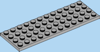
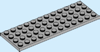
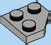
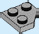
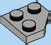
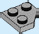
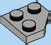
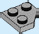
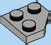
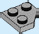
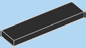
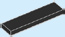
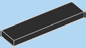
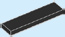
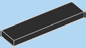
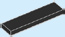
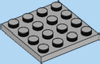
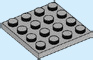
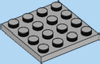
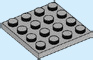
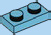
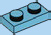
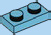
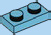
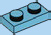
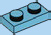
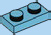
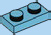
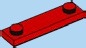
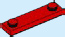
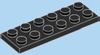
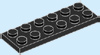
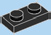
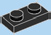
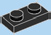
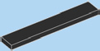
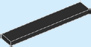
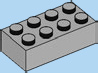
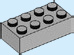
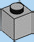
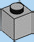
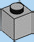
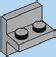
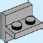
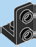
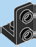
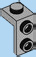
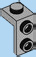
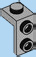
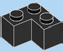
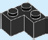
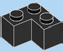
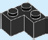
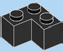
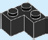
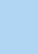
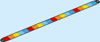
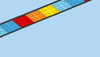
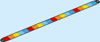
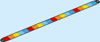
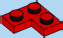
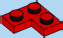
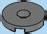
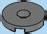
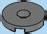
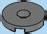
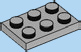
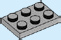
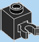
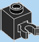
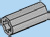
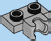
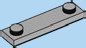
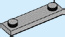
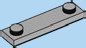
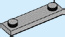
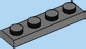
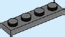
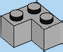
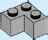
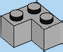
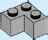
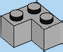
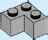
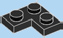
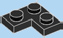
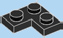
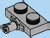
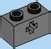
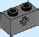
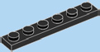
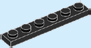
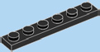
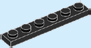
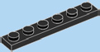
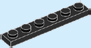
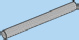
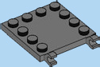
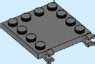
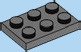
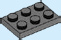
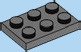
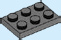
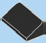
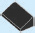
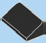
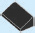
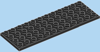
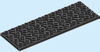
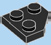
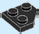
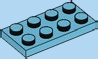
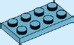
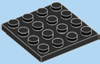
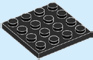
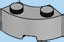
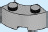
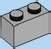
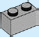
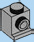
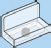
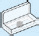
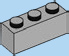
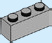
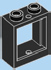
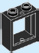
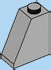
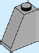
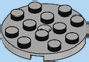
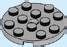
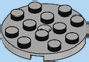
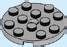
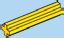
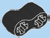
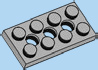
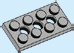
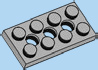
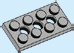
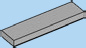
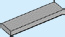
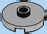
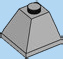
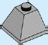
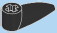
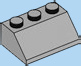
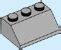
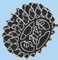
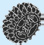
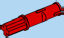
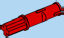
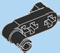
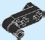
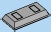
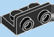
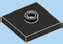
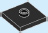
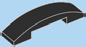
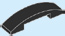
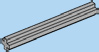
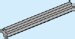
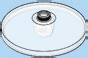
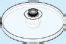
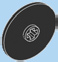
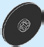
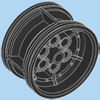
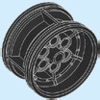
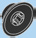
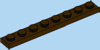
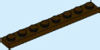
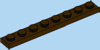
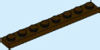
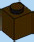
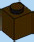
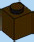
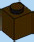
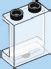
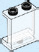
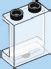
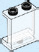
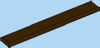
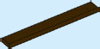
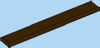
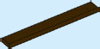
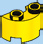
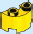
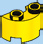
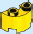
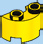
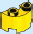
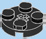
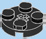
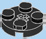
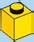
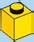
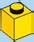
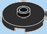
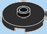

Unmatched step pieces for manual ID 6497658



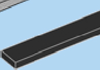
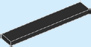
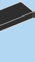
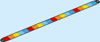
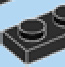
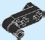
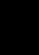
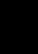
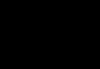
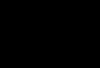
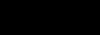
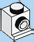
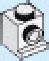
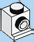
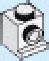
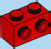
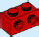

Matched step pieces for manual ID 6497660



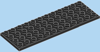
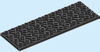
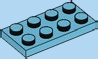
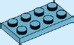
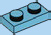
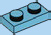
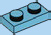
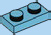
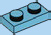
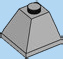
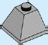
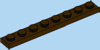
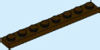
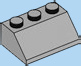
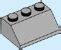
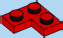
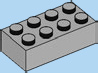
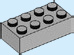
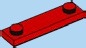
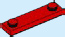
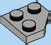
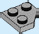
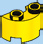
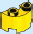
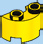
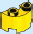
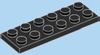
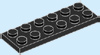
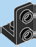
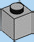
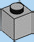
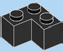
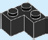
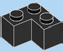
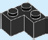
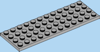
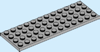
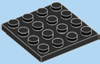
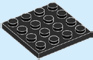
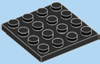
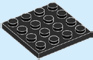
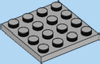
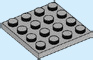
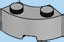
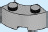
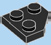
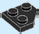
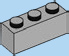
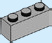
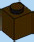
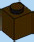
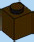
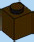
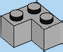
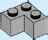
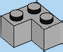
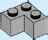
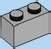
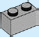
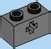
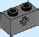
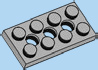
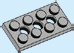
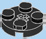
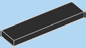
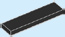
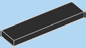
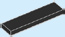
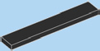
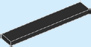
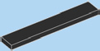
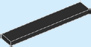
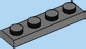
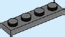
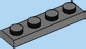
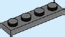
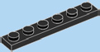
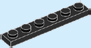
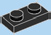
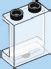
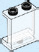
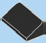
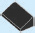
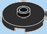
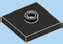
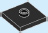
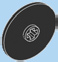
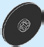
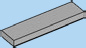
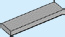
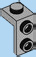
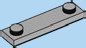
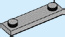
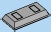
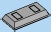
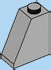
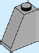
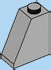
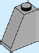
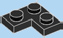
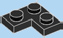
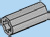
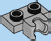
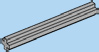
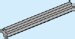

Unmatched step pieces for manual ID 6497660



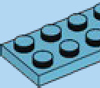
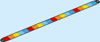
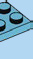
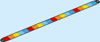
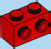
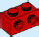
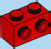
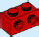

Matched step pieces for manual ID 6497659



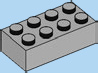
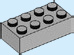
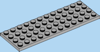
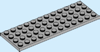
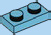
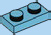
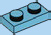
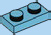
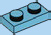
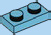
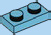
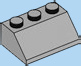
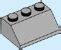
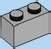
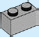
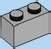
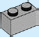
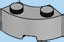
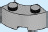
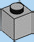
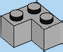
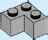
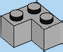
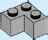
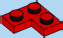
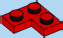
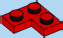
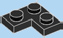
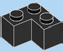
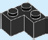
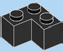
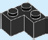
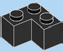
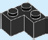
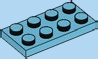
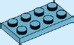
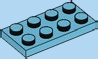
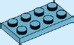
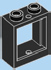
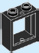
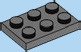
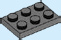
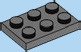
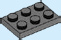
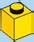
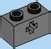
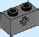
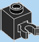
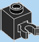
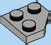
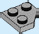
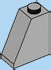
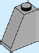
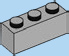
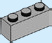
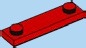
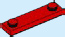
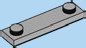
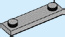
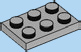
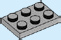
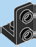
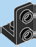
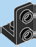
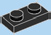
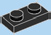
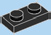
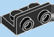
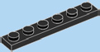
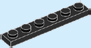
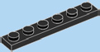
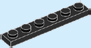
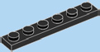
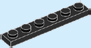
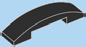
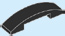
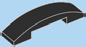
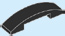
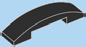
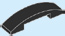
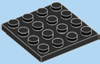
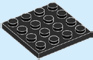
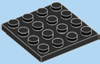
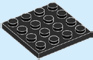
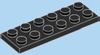
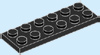
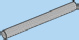
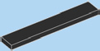
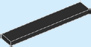
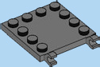
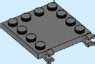
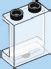
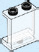
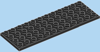
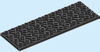
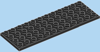
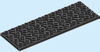
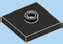
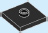
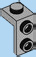
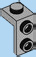
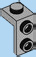
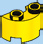
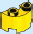
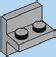
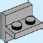
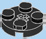
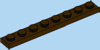
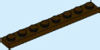
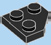
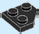
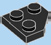
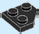
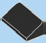
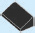
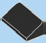
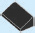
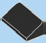
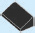
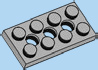
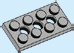
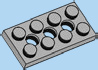
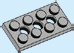
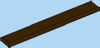
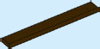
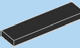
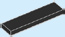
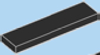
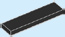
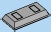
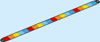
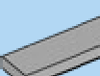
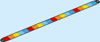
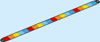
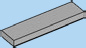
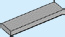
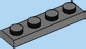
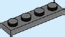
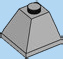
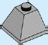
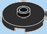
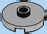
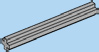
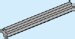
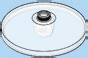
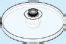
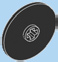
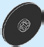
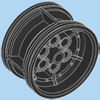
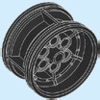

Unmatched step pieces for manual ID 6497659



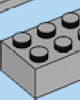
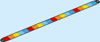
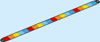
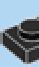
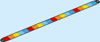
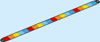
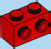
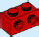
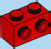
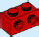
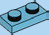
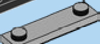

In [15]:
# Create the comparison DataFrame for each processed manual
for manual, matcher in matchers.items():
    print("Matched step pieces for manual ID", manual)
    matched_df = matcher.display_comparison_dataframe()
    print("Unmatched step pieces for manual ID", manual)
    unmatched_df = matcher.display_comparison_dataframe(compare_unmatched=True)

## Store the steps data in the database

In [34]:
# Debug
db_path = "sqlite:///test_db.db"
setup_logging(log_to_console=False, log_level=logging.DEBUG)

for manual, _ in manuals:
    if manual not in matchers:
        logger.warning("No matching data for manual ID {manual}")
        continue
    process_and_load_manual_data(
        matchers[manual].matched, manuals_to_sets, inventories_csv, db_path, int(manual)
    )